In [1]:
# 验证码识别器训练 
# Reference: https://github.com/ypwhs/captcha_break

In [2]:
# 导入所有需要的库
import numpy as np
import pandas as pd
np.random.seed(0)
from keras.models import Model,load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, AveragePooling2D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from unicodedata import normalize
from keras import regularizers
from keras.applications import inception_resnet_v2
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from PIL import Image as Image__
import glob
from sklearn.model_selection import train_test_split
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
%pylab inline
import random
%config InlineBackend.figure_format = 'retina'
import string
import cv2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
from keras.utils import multi_gpu_model

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
(80, 170, 3)


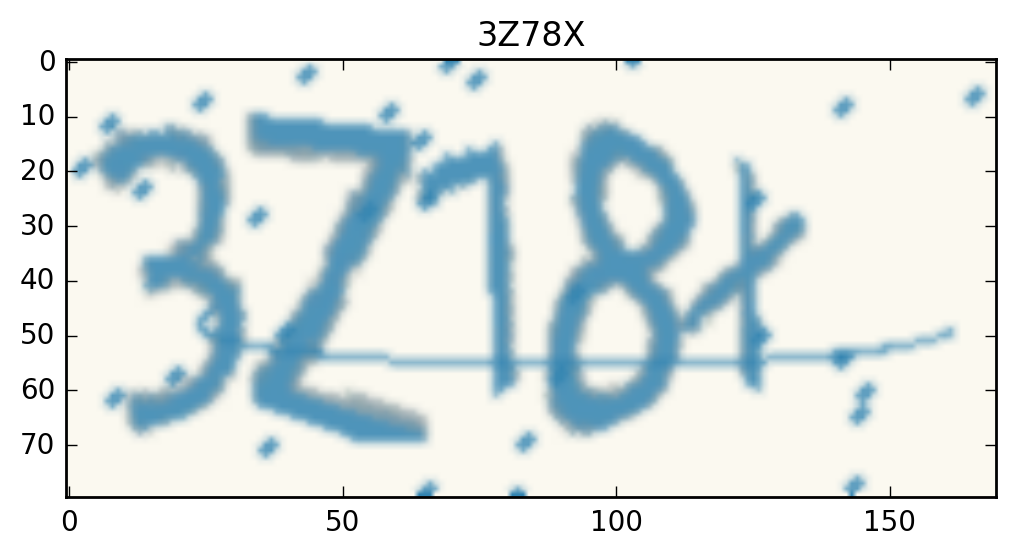

In [4]:
# 随机生成一个5位验证码图片
# 让captcha生成大小170*80图片大小，如果过小会显示错位
# 然后放大图片，因为keras的预训练模型不支持139*139以下图片
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 5, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(5)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)
print(np.asarray(img).shape)

In [5]:
# 定义训练集batch生成器，每次可生成batchsize个图片
def gen_code(batch_size=32):
    X = np.zeros((batch_size, height*4, width*4, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            img = generator.generate_image(random_str)
            img = Image__.fromarray(cv2.resize(np.asarray(img), (width*4, height*4)))
            X[i] = img
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield np.array(X), y

In [6]:
# 测试生成器
def test_gen():
    X,y = next(gen_code(batch_size=1))
    index = np.argmax(np.array(y),2)[:,0]
    digits = ''.join([characters[i] for i in index])
    plt.imshow(X[0])
    plt.title(digits)

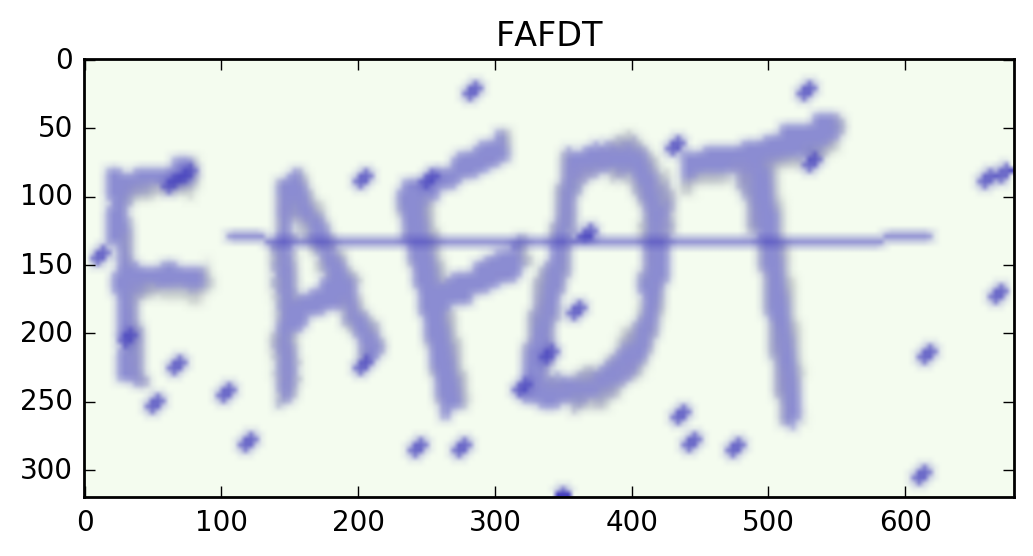

In [7]:
test_gen()

In [17]:
input_ = Input((height*4, width*4, 3))
X = input_
for i in range(5):
    X = Conv2D(32*2**i, (3, 3), activation='relu')(X)
    X = Conv2D(32*2**i, (3, 3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
X = Flatten()(X)
X = Dropout(0.25)(X)
outputs = [Dense(n_class, activation='softmax')(X) for i in range(5)]

In [18]:
model = Model(inputs=[input_], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
#model.summary()

In [21]:
# 时间超级尼玛长
parallel_model = multi_gpu_model(model, gpus=8)

### for layer in model.layers[:-2]:
    layer.trainable = False

### for i in model.layers:
    i.trainable = True

In [23]:
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# 训练
parallel_model.fit_generator(gen_code(batch_size=32),validation_data=gen_code(batch_size=32), 
                             steps_per_epoch=5120,epochs=3 , validation_steps=1280)

Epoch 1/3
  99/5120 [..............................] - ETA: 58:44 - loss: 18.4785 - dense_16_loss: 3.7188 - dense_17_loss: 3.7141 - dense_18_loss: 3.6833 - dense_19_loss: 3.6906 - dense_20_loss: 3.6718 - dense_16_acc: 0.0265 - dense_17_acc: 0.0268 - dense_18_acc: 0.0294 - dense_19_acc: 0.0287 - dense_20_acc: 0.0306       

KeyboardInterrupt: 